In [1]:
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import os
import math
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy.core.multiarray

# Model-specific imports
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import datasets
import xgboost as xgb

# Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score, precision_score, recall_score, f1_score
import shap

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
o = os.getcwd()
data = pd.read_csv(o + "/../data/cases_train_processed.csv", parse_dates=True)
model_path = o + "/../models/"
plot_path = o + "/../plots/"
xgpath = model_path + 'xgbModel.pkl'
xg_pass = 'xg'

In [3]:
def categorize_column(data):
    i = 0
    for value in tqdm(data.unique()):
        data.replace(value, i, inplace=True)
        i += 1
    data = data.apply(pd.to_numeric)
    return data

In [27]:
def build_model(train, val):

    print('XGBoost Model:\n')

    print('1\tSetting training variables')
    dtrain = train.drop(columns='outcome')
    dval = val.drop(columns='outcome')
    dt_label = train['outcome']
    dv_label = val['outcome']

    print('2\tSetting custom XGB DMatrices...')
    xg_dtrain = xgb.DMatrix(dtrain, label=dt_label)
    xg_dval = xgb.DMatrix(dval, label=dv_label)
    xg_test = xgb.DMatrix(dtrain, label=dt_label)

    print('3\tSetting parameters...')
    param = {
        'objective': 'multi:softmax',
        'max_depth': 6,
        'eta': 0.05,
        'subsample': 0.5,
        'colsample_bytree': 0.5,
        'num_parallel_tree': 1,
        'min_child_weight': 10, # originally was 1000
        'gamma': 100,
        'num_class': 4
    }
    evallist = [(xg_dval, 'eval'), (xg_dtrain, 'train')]
    num_round = 500
    early_stopping_rounds = 3

    

    # XGB training GO!
    print('***\tXGB Initiate\t***')
    xgb_model = xgb.train(param, xg_test, num_round, evallist,
                          early_stopping_rounds=early_stopping_rounds)
    print('***\tCOMPLETE\t***')
    return xgb_model

In [10]:
def evaluate(train, val, model, string):

    dtrain = train.drop(columns='outcome')
    dval = val.drop(columns='outcome')
    dt_label = train['outcome']
    dv_label = val['outcome']

    train_prediction = [round(value) for value in dt_label]  # from training
    prediction = [round(value) for value in dv_label]  # from validation

    print('1\tAccuracy measure:\n')
    model_predict = None
    cm_labels = train['outcome'].unique().tolist()

    if(string == xg_pass):
        print('Setting up XGBoost vars & model prediction...\n')
        xg_dtrain = xgb.DMatrix(dtrain, label=dt_label)
        xg_dval = xgb.DMatrix(dval, label=dv_label)
        model_predict = model.predict(xg_dval)
        train_accuracy = accuracy_score(
            model.predict(xg_dtrain), train_prediction)
    else:
        model_predict = model.predict(dval)
        train_accuracy = accuracy_score(
            model.predict(dtrain), dt_label)
    
    print("\tTrain Accuracy: \t%.2f%%" % (train_accuracy * 100.0))
    accuracy = accuracy_score(model_predict, prediction)
    print("\tValidation Accuracy: \t%.2f%%" % (accuracy * 100.0))
    print('\n')

    print('2\tConfusion Matrix:\n')
    cm = confusion_matrix(dv_label,model_predict, labels = cm_labels)
    print(cm)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + cm_labels)
    ax.set_yticklabels([''] + cm_labels)
    plt.xlabel('Predicted Values')
    plt.ylabel('Actual Values')

    print('3\tPrecision, Recall & F-Score:\n')
    precision = precision_score(dv_label, model_predict, average="macro")
    print('\tPrecision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(dv_label, model_predict, average="macro")
    print('\tRecall: %f' % recall)
    # f1: tp / (tp + fp + fn)
    f1 = f1_score(dv_label, model_predict, average="macro")
    print('\tF1 score: %f' % f1)
    print('\n')

    # if(string == xg_pass):
    #     print('4\tSHAP Bar Of Importance:\n')
    #     explainer = shap.TreeExplainer(model)
    #     shap_values = explainer.shap_values(dval)
    #     shap.summary_plot(shap_values, dval, plot_type="bar", show=False)


In [18]:
print("\n\nTeam Losers: Milestone 3\n\n")
print("Modifying data for classifiers...\n")

# data = pd.read_csv( o + "\\..\\data\\cases_train_processed.csv", parse_dates=True)
data = pd.read_csv(o + "/../data/cases_train_processed.csv", parse_dates=True)
data['sex'] = categorize_column(data['sex'])
data['outcome'] = categorize_column(data['outcome'])
data['Combined_Key'] = categorize_column(data['Combined_Key'])


# might need to drop date column if classifiers can't handle it
data = data.drop(columns=['province', 'country'])
#data = data.drop(columns=['date_confirmation'])

print("Splitting data into test and validation sets...\n")

train, val = train_test_split(
    data, test_size=0.2, random_state=69, shuffle=True)



Team Losers: Milestone 3


Modifying data for classifiers...

100%|██████████| 496/496 [00:43<00:00, 11.51it/s]
Splitting data into test and validation sets...



Building training models...

XGBoost Model:

1	Setting training variables
2	Setting custom XGB DMatrices...
3	Setting parameters...
***	XGB Initiate	***
[00:00:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-mlogloss:1.32853	train-mlogloss:1.32846
[1]	eval-mlogloss:1.27539	train-mlogloss:1.27537
[2]	eval-mlogloss:1.22686	train-mlogloss:1.22662
[3]	eval-mlogloss:1.18244	train-mlogloss:1.18213
[4]	eval-mlogloss:1.14138	train-mlogloss:1.14114
[5]	eval-mlogloss:1.10311	train-mlogloss:1.10285
[6]	eval-mlogloss:1.06796	train-mlogloss:1.06761
[7]	eval-mlogloss:1.03522	train-mlogloss:1.03484
[8]	eval-mlogloss:1.00476	train-mlogloss:1.00438
[9]	eval-mlogloss:0.97691	train-mlogloss:0.97640
[10]	eval-mlogloss:0.94993	train-mlogloss:0.94947
[11]	eval-mlogloss:0.9250

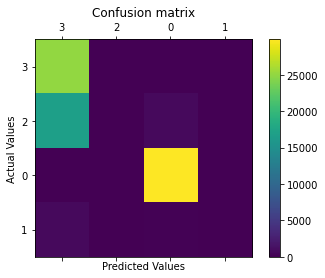

In [28]:
print("Building training models...\n")
xg_model = build_model(train, val)

print("Model building completed, Evaluating models...\n")
evaluate(train, val, xg_model, xg_pass)